Esta fase de la metdologia consiste en extraer el valor de los datos desarrollando un modelo que aprenda de los patrones en estos.

* El diagrama en cuestion de esta fase esta a continuacion:

![Imagen_mapa](imagen_modelado_general.png)

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator #generator de imagenes
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

In [2]:
tf.keras.backend.clear_session()

### Canalizacion de datos

* Preparamos la canalizacion de datos, a partir de las imagenes del disco.

In [3]:
train_datagen=ImageDataGenerator(
            rescale=1.0/255, #escalamos los datos en rangos de [-1,1] El modelo MobileNetv2 espera esta configuracion
            rotation_range = 45,
            zoom_range = 0.2,
            shear_range = 0.2,
            width_shift_range = 0,
            height_shift_range = 0,
            horizontal_flip=True,
            vertical_flip = False,
            fill_mode = 'nearest'
        )
#sobre los datos de validacion y test no se hace ningun aumento de datos.
validation_datagen=ImageDataGenerator(rescale=1.0/255) #escalamiento de validacion a un rango de [0,1]
test_datagen=ImageDataGenerator(rescale=1.0/255)       #escalamiento de test a un rango de [0,1]

In [4]:
#definimos las rutas para el acceso a los datos
train_path="../input/datasetscovidsplit/Datasets/train"
validation_path="../input/datasetscovidsplit/Datasets/val"
test_path="../input/datasetscovidsplit/Datasets/test"

#creamos los generadores de datos a partir de los flujos de informacion
BATCH_SIZE=32 #tamaño del lote que se ira pasando poco a poco
IMAGE_SIZE=(256,256)

train_generator=train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator=train_datagen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator=train_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 15238 images belonging to 4 classes.
Found 1694 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.


### Seleccion de tecnica de balanceo de clases

* Para ello usaremos la libreria sklearn con las funcionalidad de class_weights para obtener las ponderaciones de las clases y poder usarlas a favor de las clases minoritarias.

* Podemos balancear las clases generando muestras sinteticas como SMOTE oversampling o reduciendo las muestras de las clases mayoritarias a menor proporcion equivalente a las clases minoritarias.

* En nuestro caso trabajamos con imagenes, y tenemos la opcion de tratar este desbalanceo **penalizando los pesos de las clases** mayoritarias a favor de las clases minoritarias.

Para ellos obtendremos la proporcion de clases en el generador de datos para aplicar la penalizacion despues.

In [5]:


unique_classes=np.unique(train_generator.classes) #la ponderacion se obtiene con los datos de entrenamiento
total_classes=train_generator.classes

class_weights=class_weight.compute_class_weight(
                                        "balanced", #modo de obtencion de pesos de las clases,
                                        unique_classes,
                                        total_classes
)
class_weights=dict(enumerate(class_weights))
print(class_weights)

{0: 1.462941628264209, 1: 0.8801987060998152, 2: 0.5191469065140365, 3: 3.9354338842975207}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[0 0 0 ... 3 3 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [6]:
#tratemos de obtener el peso asociado a cada clase
for label,index in train_generator.class_indices.items():
    print(label,class_weights[index])

COVID 1.462941628264209
Lung_Opacity 0.8801987060998152
Normal 0.5191469065140365
Viral Pneumonia 3.9354338842975207


### Selección de tecnicas de Modelado

Al tratarse de un problema de clasificacion de imagenes entre los posibles candidatos tenemos:

* MultiLayer Pereptron: Red neuronal de capas densamente conectadas
* Convolutional Neuronal Network: Red neuronal convolucional.
* Modelos de machine learning clasico (Maquinas de soporte vectorial, arboles de decision e impulso, etc.)

Escogi la red neuronal convolucional porque **aprende de patrones locales** como rasgos pequeños y en bloques de informacion, mientras que el **MLP** aprende de patrones especficos, e decir de todo el espacio de entrada en general.


### Construcción de la arquitectura del modelo

* Para la construccion de la arquitectura crearemos un modelo desde 0 con una arquitectura de red neuronal solida.


In [7]:
INPUT_SHAPE=(256,256,3) #imagen de 256x256 con 4 canales de datos RGB
N_CLASSES=4
BASE_LEARNING_RATE=0.001

def ConvolutionalBlock(filters,name):
    partial_block=tf.keras.models.Sequential(name=name)
    partial_block.add(tf.keras.layers.Conv2D(filters,3,activation="relu",padding="same"))
    partial_block.add(tf.keras.layers.Conv2D(filters,3,activation="relu",padding="same"))
    partial_block.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    return partial_block

def DenseBlock(units,name):
    dense_block=tf.keras.models.Sequential(name=name)
    dense_block.add(tf.keras.layers.Dense(units,activation="relu"))
    dense_block.add(tf.keras.layers.Dropout(0.2))
    
    return dense_block

def build_base_model():
    #arquitectura del modelo
    inputs=tf.keras.Input(shape=INPUT_SHAPE,name="input")
    x=ConvolutionalBlock(64,"conv_block_64")(inputs)
    x=ConvolutionalBlock(128,"conv_block_128")(x)
    x=ConvolutionalBlock(256,"conv_block_256")(x)
    x=ConvolutionalBlock(512,"conv_block_512")(x)
    
    x=tf.keras.layers.BatchNormalization(name="batch_normalization")(x)
    x=tf.keras.layers.GlobalAveragePooling2D(name="average_intermedio")(x)
    
    x=tf.keras.layers.Dense(512,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    x=tf.keras.layers.Dense(256,activation="relu")(x)
    x=tf.keras.layers.Dense(128,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    
    outputs=tf.keras.layers.Dense(N_CLASSES,activation="softmax",name="output")(x)
    
    model=tf.keras.Model(inputs,outputs,name="model_covid_detector")
    #compilacion del modelo
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Recall(name="recall")    
        ]
    )
    
    return model
    

In [8]:
test_model=build_base_model()

In [9]:
test_model.summary()

Model: "model_covid_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv_block_64 (Sequential)   (None, 128, 128, 64)      38720     
_________________________________________________________________
conv_block_128 (Sequential)  (None, 64, 64, 128)       221440    
_________________________________________________________________
conv_block_256 (Sequential)  (None, 32, 32, 256)       885248    
_________________________________________________________________
conv_block_512 (Sequential)  (None, 16, 16, 512)       3539968   
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 512)       2048      
_________________________________________________________________
average_intermedio (GlobalAv (None, 512)      

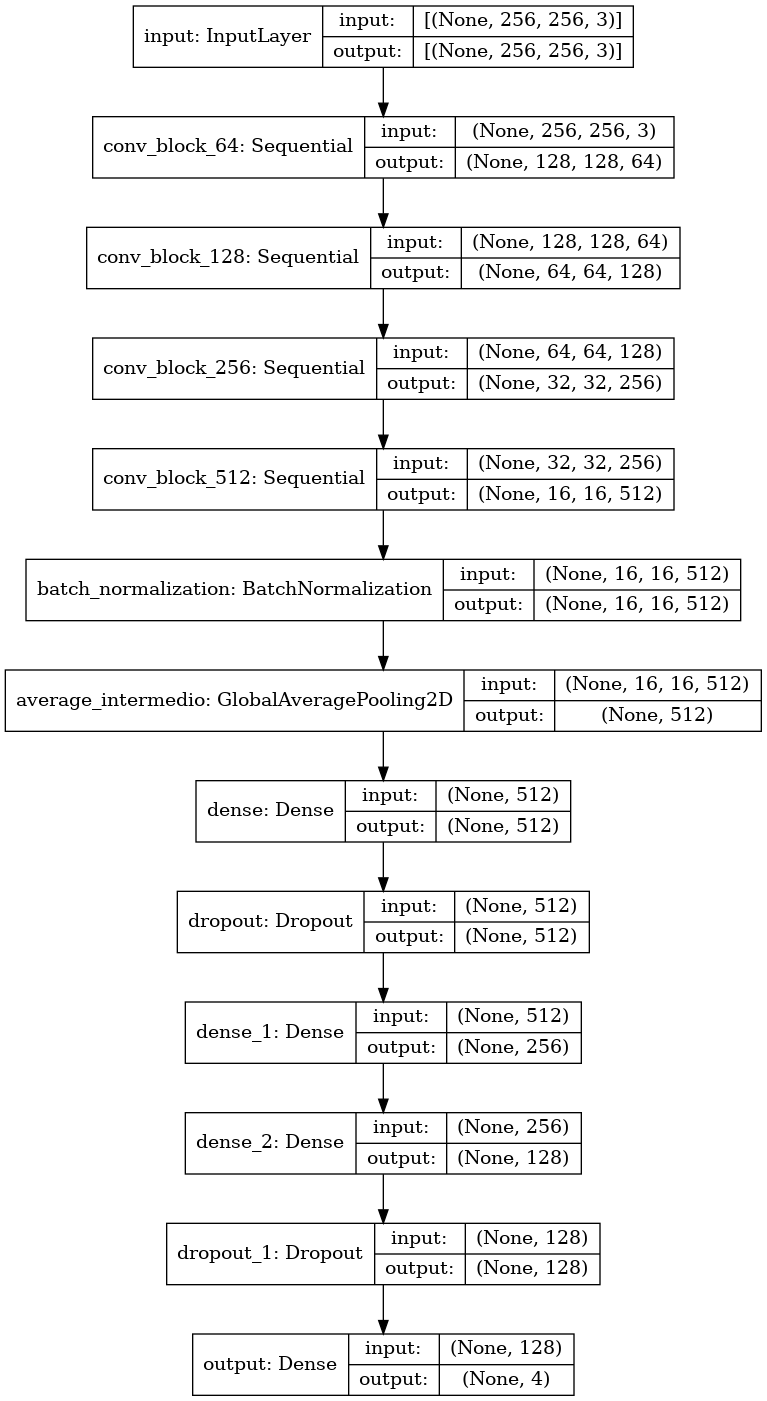

In [10]:
plot_model(test_model,"model_build.png",show_shapes=True)

Una vez obtenidos la arquitectura del modelo
* Generando **Callbacks** para detener el entrenamiento cuando no se tienen buenos resultados


In [11]:
#cuando la funcion de perdida ya no mejora en los datos de validacion.
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,
                                                mode="min",
                                                restore_best_weights=True) 
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("base_model_best_check.h5",save_best_only=True)
n_epochs=50

### Entrenamiento el modelo BASE


In [12]:
base_model=build_base_model()
model_history=base_model.fit(
                    train_generator,
                    epochs=n_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    callbacks=[early_stopping,model_checkpoint],
                    class_weight=class_weights,#penalizacion de pesos para el balanceo,
                    workers=8
            )

Epoch 1/50
477/477 [==============================] - 255s 513ms/step - loss: 1.2164 - accuracy: 0.3939 - recall: 0.1444 - val_loss: 1.5220 - val_accuracy: 0.3191 - val_recall: 0.2758
Epoch 2/50
477/477 [==============================] - 246s 509ms/step - loss: 0.8765 - accuracy: 0.5774 - recall: 0.4335 - val_loss: 1.9539 - val_accuracy: 0.3089 - val_recall: 0.3029
Epoch 3/50
477/477 [==============================] - 248s 511ms/step - loss: 0.7677 - accuracy: 0.6153 - recall: 0.5071 - val_loss: 1.0119 - val_accuracy: 0.5559 - val_recall: 0.5162
Epoch 4/50
477/477 [==============================] - 243s 504ms/step - loss: 0.6857 - accuracy: 0.6646 - recall: 0.5702 - val_loss: 1.3244 - val_accuracy: 0.3852 - val_recall: 0.3143
Epoch 5/50
477/477 [==============================] - 247s 510ms/step - loss: 0.6225 - accuracy: 0.6947 - recall: 0.6173 - val_loss: 1.5267 - val_accuracy: 0.4357 - val_recall: 0.4038
Epoch 6/50
477/477 [==============================] - 246s 510ms/step - loss: 0.

In [14]:
#guardamos el modelo generado
base_model.save("model_base.h5")

In [15]:

#deseo guardar el History devuelto del entrenamiento
dfhist=pd.DataFrame(model_history.history)
dfhist.to_csv("./model_history.csv",index=False)

Trazamos la curva de la accuracy y funcion de perdida

* Creamos una funcion para reutilizar la funcion que genera el grafico, para los modelos que se probaran mas adelante.

In [20]:

def plot_metrics(history,metrics=[]): #retorna una lista de tuplas
    fig,axes=plt.subplots(1,len(metrics))
    fig.set_size_inches(15,5)
    graph=pd.DataFrame(history)
    for i,ax in enumerate(axes.flat):
        graph[list(metrics[i])].plot(kind="line",style="-",ax=ax)
        ax.set_title(" VS ".join(list(metrics[i])))
        ax.grid(True)
    plt.show()

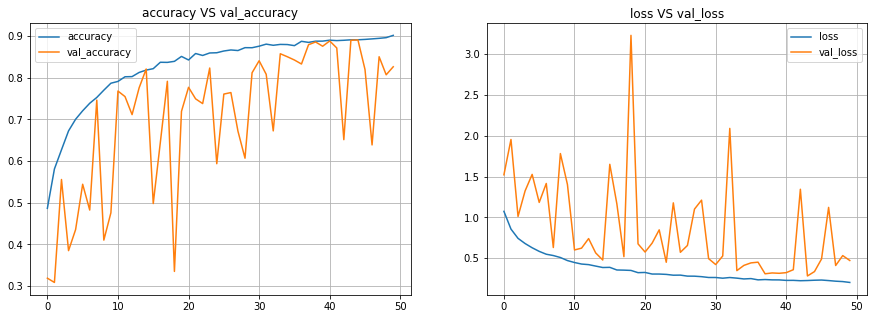

In [21]:
df_history=pd.read_csv("model_history.csv")
history=df_history.to_dict("list")
metrics=[("accuracy","val_accuracy"),("loss","val_loss")]
plot_metrics(history,metrics=metrics)

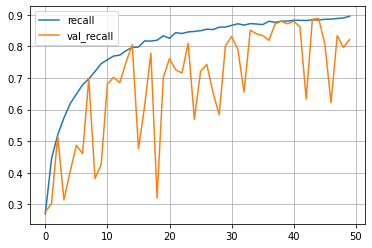

In [23]:
df_history[["recall","val_recall"]].plot(kind="line",style="-")
plt.grid(True)

In [24]:
#obtenemos el numero de epocas donde se detuvo y lo configuramos como un epoch inicial para el siguiente
#entrenamiento
EPOCH_STOP=model_history.epoch[-1]
print("El modelo se entreno en",EPOCH_STOP,"Epochs")

El modelo se entreno en 49 Epochs


* El entrenamiento del modelo se detuvo en 20 epochs lo que nos dice que la funcion de perdida en la data de validacion no mejoro por 5 epochs consecutivos, probablemente, ya no mejore para futuras epocas.

Ahora veamos el rendimiento del modelo base en los datos de entrenamiento y validacion

In [26]:
base_model.evaluate(train_generator)

477/477 [==============================] - 231s 485ms/step - loss: 0.3987 - accuracy: 0.8447 - recall: 0.8330


[0.3987157344818115, 0.8447302579879761, 0.833048939704895]

In [27]:
base_model.evaluate(validation_generator)

53/53 [==============================] - 29s 539ms/step - loss: 0.4648 - accuracy: 0.8341 - recall: 0.8241


[0.4648427367210388, 0.8341204524040222, 0.824084997177124]

* Mostramos la matriz de confusion en los datos de entrenamiento y validacion

Para el conjunto de entrenamiento

In [28]:
y_true=train_generator.classes
predictions=base_model.predict(train_generator)
y_pred=np.argmax(predictions,axis=1)

In [29]:
train_generator.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

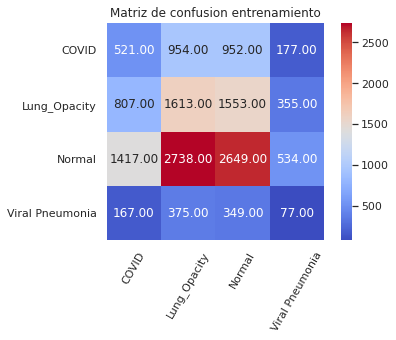

In [31]:
#obtenemos la matriz de confusion de sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
classes=train_generator.class_indices.keys()
mat_train=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_train,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion entrenamiento")
plt.show()

* Reporte de clasificacion para el conjunto de entrenamiento

In [36]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                 precision    recall  f1-score   support

          COVID       0.17      0.18      0.17       289
   Lung_Opacity       0.30      0.40      0.34       481
         Normal       0.46      0.34      0.39       816
Viral Pneumonia       0.04      0.06      0.05       108

       accuracy                           0.31      1694
      macro avg       0.24      0.24      0.24      1694
   weighted avg       0.34      0.31      0.32      1694



* Para el conjunto de validacion

In [34]:
y_true=validation_generator.classes
predictions=base_model.predict(validation_generator)
y_pred=np.argmax(predictions,axis=1)

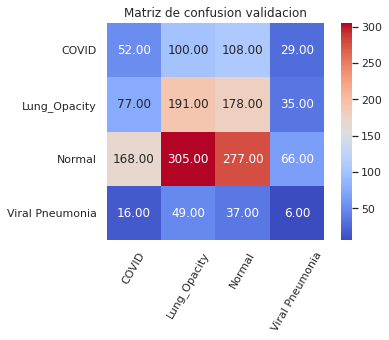

In [37]:
classes=validation_generator.class_indices.keys()
mat_val=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_val,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion validacion")
plt.show()

* Reporte de clasificacion para los datos de validacion

In [38]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                 precision    recall  f1-score   support

          COVID       0.17      0.18      0.17       289
   Lung_Opacity       0.30      0.40      0.34       481
         Normal       0.46      0.34      0.39       816
Viral Pneumonia       0.04      0.06      0.05       108

       accuracy                           0.31      1694
      macro avg       0.24      0.24      0.24      1694
   weighted avg       0.34      0.31      0.32      1694



### RESULTADOS FINALES: MODELO BASE
* El modelo base ha obtenido un puntaje de accuracy **ACC=84%** y recall **RECALL=83.0%** en el **conjunto de entrenamiento**.

* El modelo ha obtendio un puntaje de accuracy **ACC=83.%** y recall **RECALL=82.%** en el **conjunto de validacion**.

**IMPORTANTE**: El modelo ha alcanzado un poco equilibrio entre los datos de entrenamiento y validacion, lo que siginifica que es un modelo final con aproximadamente 82% de precision. Este modelo pasará a la **Fase de evaluación del modelo**.